In [1]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

sys.path.append("../scripts")
sys.path.append("../src/iw_model")
sys.path.append("../src/iw_inverse")
sys.path.append("../src/misc")
from iw_invert import InternalWaveInversion
from extract import *

In [2]:
"""
Read data and compute means, extrapolate isopyncnal displacments
"""
path = os.path.join("..","matlab",filename)

table = read_table(path)
N2 = extract_node(table,'N2')
T  = extract_node(table,'T')
S  = extract_node(table,'S')
Z  = extract_node(table,'z').flatten()

#Compute the mean stratification
DSL = slice(20,70) # depth slice
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean[DSL],T_mean[DSL],Z[DSL])

#Define a slice
sl = (slice(0,-1),DSL,slice(0,-1),slice(0,-1))

#Subsample matrices
TP = T[sl]
SP = S[sl]
NP = N2[sl]

#Grab Axes Data
TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Convert matlab timestamps
t0 = matlab2datetime(TIME[0]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0) for T in TIME]
X = 1e3*np.arange(0,22,2)
Y = 1e3*np.arange(0,22,2)

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,X,Y])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(TP.shape)

#Compute Density from state variables
RP = sw.eos80.dens(SP,TP,AX['z'])

#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z[DSL])
DZ   = zofr(RP) - AX['z']



In [10]:
"""
Compute Inversion Single Line
"""
#Pick a single point in time construct dataframe
slit = pd.DataFrame({"dz"    : DZ[0:100,:,0,0].T.flatten(),
                     "time"  : AX[0:100,:,0,0]["t"].T.flatten(),
                     "z"     : AX[0:100,:,0,0]["z"].T.flatten(),
                     "x"     : 0,
                     "y"     : 0
                    })

slit['date'] = pd.to_datetime(slit['time'] + t0, unit='s')

#Set up parameter space
FREQS = [0,.0805/3600,2*.0805/3600]
FREQS += list(np.arange(1/24,1/2,1/60)/3600)
MODES = np.arange(1,50)

#Run inversion
subdf = slit[slit['time'] < 3*max(slit['time'])/6]
iwi = InternalWaveInversion(subdf,FREQS,MODES,[0],Z[DSL],N2_mean[DSL],tc='dz')
iwi.pinvert()

#Compute an estimate
iwi_full = InternalWaveInversion(slit,FREQS,MODES,[0],Z[DSL],N2_mean[DSL],tc='dz')

slit['dz_hat'] = iwi_full.H @ np.concatenate([iwi.ps['a'],iwi.ps['b']]).T
slit['err'] = slit['dz_hat'] - slit['dz']



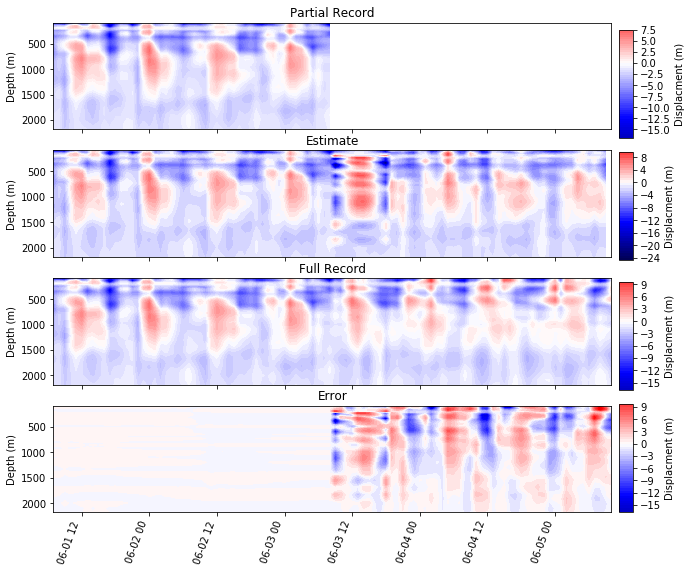

In [11]:
%autoreload
import iw_plots as iwp
"""
Plotting Forecasts
"""

f, ax = plt.subplots(4,1,sharex=True)
cnorm = (-25,0,25)
p1 = iwp.plot_dataframe_slice(subdf,'date','z','dz',ax[0],cnorm=(cnorm))
p2 = iwp.plot_dataframe_slice(slit[slit['time'] < 6*max(slit['time'])/6],'date','z','dz_hat',ax[1],cnorm=(cnorm))
p3 = iwp.plot_dataframe_slice(slit,'date','z','dz',ax[2],cnorm=(cnorm))
p4 = iwp.plot_dataframe_slice(slit,'date','z','err',ax[3],cnorm=(cnorm))
ax[0].set_title('Partial Record')
ax[1].set_title('Estimate')
ax[2].set_title('Full Record')
ax[3].set_title('Error')

for a in ax:
    a.set_ylabel('Depth (m)')
f.autofmt_xdate(rotation=70)
cax1 = f.add_axes([.91, 0.72, 0.02, 0.15])
cax2 = f.add_axes([.91, 0.55, 0.02, 0.15])
cax3 = f.add_axes([.91, 0.37, 0.02, 0.15])
cax4 = f.add_axes([.91, 0.2, 0.02, 0.15])
f.colorbar(p1,cax=cax1,label="Displacment (m)")
f.colorbar(p2,cax=cax2,label="Displacment (m)")
f.colorbar(p3,cax=cax3,label="Displacment (m)")
f.colorbar(p3,cax=cax4,label="Displacment (m)")
f.set_size_inches(10,10)